In [1]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import collections
import matplotlib.pyplot as plt

In [5]:
label_img = Image.open("label.png").convert('L')
original_img = Image.open("original_img.jpg").convert('RGB')
warp_mask = Image.open("warp_mask.jpg").convert('L')

In [6]:
def get_transform(method=Image.BICUBIC, normalize=True):
    transform_list = []  
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img, 512, method)))
    osize = [256,192]
    transform_list.append(transforms.Resize(osize, method))  

    transform_list += [transforms.ToTensor()]

    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img    
    w = target_width
    h = int(target_width * oh / ow)    
    return img.resize((w, h), method)

In [7]:
#Label images processing
transform_A = get_transform(method=Image.NEAREST, normalize=False)
label_tensor = transform_A(label_img) * 255.0
label_tensor.shape

torch.Size([1, 256, 192])

In [8]:
#original image processing
transform_B = get_transform()
original_tensor = transform_B(original_img)
original_tensor.shape

torch.Size([3, 256, 192])

In [9]:
#warp mask processing
warp_tensor = transform_A(warp_mask) 
warp_tensor.shape

torch.Size([1, 256, 192])

In [10]:
t_mask = torch.FloatTensor((label_tensor.cpu().numpy()==7).astype(np.float))
label_tensor = label_tensor*(1-t_mask)+t_mask*4
hair_mask = torch.FloatTensor((label_tensor.cpu().numpy()==1).astype(np.int))

In [11]:
#saving the hair mask with the occlusion part for visualization
hair_and_occlusion = warp_tensor * hair_mask
cv_img=(hair_and_occlusion.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('hair_occlusion.jpg',rgb)

True

In [12]:
#saving the occlusion part
warp_array = warp_tensor.cpu().numpy()
warp_array = np.where(warp_array > 0.9, 1, 0)
warp_adjusted_tensor = torch.FloatTensor(warp_array)
#warp_tensor = warp_tensor * hair_mask * 2 -1
warp_final_tensor = warp_adjusted_tensor * hair_mask
#test = hair_mask - warp_tensor
cv_img=(warp_final_tensor.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('target_clothes_hair_occlusion.jpg',rgb)

True

In [13]:
#save the original hair part which is affected in occlusion
original_hair_occlusion = warp_final_tensor * original_tensor
cv_img=(original_hair_occlusion.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('extracted_occlusion_part.jpg',bgr)

True

In [14]:
#hair mask image 
cv_img=(hair_mask.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('hair_mask.jpg',bgr)

True

In [65]:
#save the hair part
hair_mask_img = hair_mask * original_tensor
cv_img=(hair_mask_img.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('extracted_original_hair.jpg',bgr)

True

In [67]:
upperbody_mask = torch.FloatTensor((label_tensor.cpu().numpy()==4).astype(np.int))# + torch.FloatTensor((label_tensor.cpu().numpy()==4).astype(np.int))
upper_body = upperbody_mask * original_tensor
cv_img=(upper_body.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('upperbody.jpg',bgr)

True

In [11]:
#save the original image without hair
original_no_hair = original_tensor - hair_mask_img
cv_img=(original_no_hair.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('original_without_hair.jpg',bgr)

True

In [20]:
#preprocessing the new hair
new_hair_mask = Image.open("new_hair_mask.jpg").convert('RGB')
transform_new_hair = get_transform()
new_hair_tensor = transform_new_hair(new_hair_mask)
new_hair_tensor.shape

torch.Size([3, 256, 192])

In [21]:
#preprocessing the virtual try-on result
virtual_try_on_result = Image.open("result_img_1.jpg").convert('RGB')
transform_result = get_transform()
virtual_try_tensor = transform_new_hair(virtual_try_on_result)
virtual_try_tensor.shape
#remove the hair part
virtual_res_no_hair = virtual_try_tensor - hair_mask_img

In [22]:
#new_hair_mask_img has to be the new hair image - just the hair
#multiply by the hair _mask is neccessary to only change the hair part on the image
#original_no_hair image is neccessary for the other part of the body
new_hair_mask_img = hair_mask * new_hair_tensor
new_hair_img = new_hair_mask_img * hair_mask + virtual_res_no_hair
cv_img=(new_hair_img.permute(1,2,0).detach().cpu().numpy()+1)/2
rgb=(cv_img*255).astype(np.uint8)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite('new_img.jpg',bgr)

True

# Find contours part + resize it


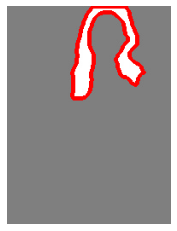

In [39]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Reading the image
im = cv2.imread('hair_mask.jpg')

# Converting image to grayscale
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Thresholding and getting contours from the image
ret, thresh = cv2.threshold(imgray, 192, 256,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im_copy = im.copy()
cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)
plt.imshow(im_copy)
plt.axis("off");

In [49]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print(cy)
    print(cx)
    print(M)
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

53
113
{'m00': 3271.5, 'm10': 369709.1666666666, 'm01': 175646.3333333333, 'm20': 43937477.25, 'm11': 19259580.208333332, 'm02': 12363134.083333332, 'm30': 5463739304.55, 'm21': 2240858571.4, 'm12': 1325319801.6, 'm03': 958110471.2, 'mu20': 2156988.8143096194, 'mu11': -590048.2571174428, 'mu02': 2932709.3810730726, 'mu30': 10887348.680037498, 'mu21': 15223762.897713229, 'mu12': -8467260.491586149, 'mu03': -20577735.82471931, 'nu20': 0.2015366538803862, 'nu11': -0.05513072231923667, 'nu02': 0.27401553106999327, 'nu30': 0.017785038937623954, 'nu21': 0.02486879256557916, 'nu12': -0.013831701543092852, 'nu03': -0.033614780204643153}


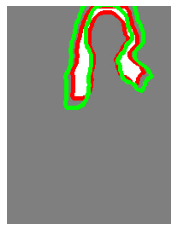

In [50]:
cnt_scaled = scale_contour(contours[0], 1.2)

im_copy = im.copy()
cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)
cv2.drawContours(im_copy, [cnt_scaled], 0, (0, 255, 0), 3)

plt.imshow(im_copy)
plt.axis("off");

# Mask coordinates

In [7]:
#this is the color what the segemntation uses
filename = "GREEN_RGB_TEST.png"
img = Image.open(filename).convert('RGB')
img.show()
hair_mask_color = img.getpixel((0,0))
hair_mask_color = np.array(hair_mask_color)
print(hair_mask_color)

[  0 128   0]


In [8]:
#load all the segmented images in a list and find the max pixel in vertical assigned for hair
max_x_values = []
for filename in glob.glob(r'C:\Users\Lenovo\OneDrive\Asztali gép\Lalaland\Checked_images\Segmented_images\*'): 
    im=Image.open(filename).convert("RGB")
    im_array = np.array(im)
    X,Y = np.where(np.all(im_array == hair_mask_color,axis=2))
    x_max = max(X)
    max_x_values.append(x_max)
max(max_x_values)

170

5623


<BarContainer object of 121 artists>

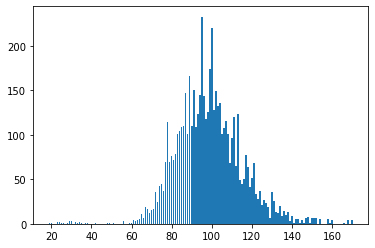

In [13]:
#check the standard diviation - plotting out
print(len(max_x_values))
w = collections.Counter(max_x_values)
plt.bar(w.keys(), w.values())

In [61]:
#find the min and max value for each image in horizontal way
min_max_horizontal = {}
for filename in glob.glob(r'C:\Users\Lenovo\OneDrive\Asztali gép\Lalaland\Checked_images\Segmented_images\*'): #assuming gif
    im=Image.open(filename).convert("RGB")
    im_array = np.array(im)
    X,Y = np.where(np.all(im_array == hair_mask_color,axis=2))
    y_min = min(Y)
    y_max = max(Y)
    y_value = [y_min,y_max]
    min_max_horizontal[filename[-22:]] = y_value

In [60]:
print(min_max_horizontal['000003_0_segmented.png'])

[43, 118]
